In [ ]:
# =========================================
# Code Block 1: Imports & Device Setup
# =========================================
import os
import copy
import random
import time 
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
multi_gpu = (num_gpus > 1)

print(f"Using device: {device}, GPU count: {num_gpus}")

# Reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)


Using device: cuda, GPU count: 2



Overall dataset counts (before split):

Apple_Bad: 1141 images
Apple_Good: 1149 images
Banana_Bad: 1087 images
Banana_Good: 1113 images
Guava_Bad: 1129 images
Guava_Good: 1152 images
Lime_Bad: 1085 images
Lime_Good: 1094 images
Orange_Bad: 1159 images
Orange_Good: 1216 images

Task 0: 1831 training samples, 459 test samples.
Task 1: 1759 training samples, 441 test samples.
Task 2: 1824 training samples, 457 test samples.
Task 3: 1743 training samples, 436 test samples.
Task 4: 1899 training samples, 476 test samples.

Task 0 label dist - Train: {0: 919, 1: 912} , Test: {0: 230, 1: 229}
Task 1 label dist - Train: {2: 890, 3: 869} , Test: {2: 223, 3: 218}
Task 2 label dist - Train: {4: 921, 5: 903} , Test: {4: 231, 5: 226}
Task 3 label dist - Train: {6: 875, 7: 868} , Test: {6: 219, 7: 217}
Task 4 label dist - Train: {8: 972, 9: 927} , Test: {8: 244, 9: 232}



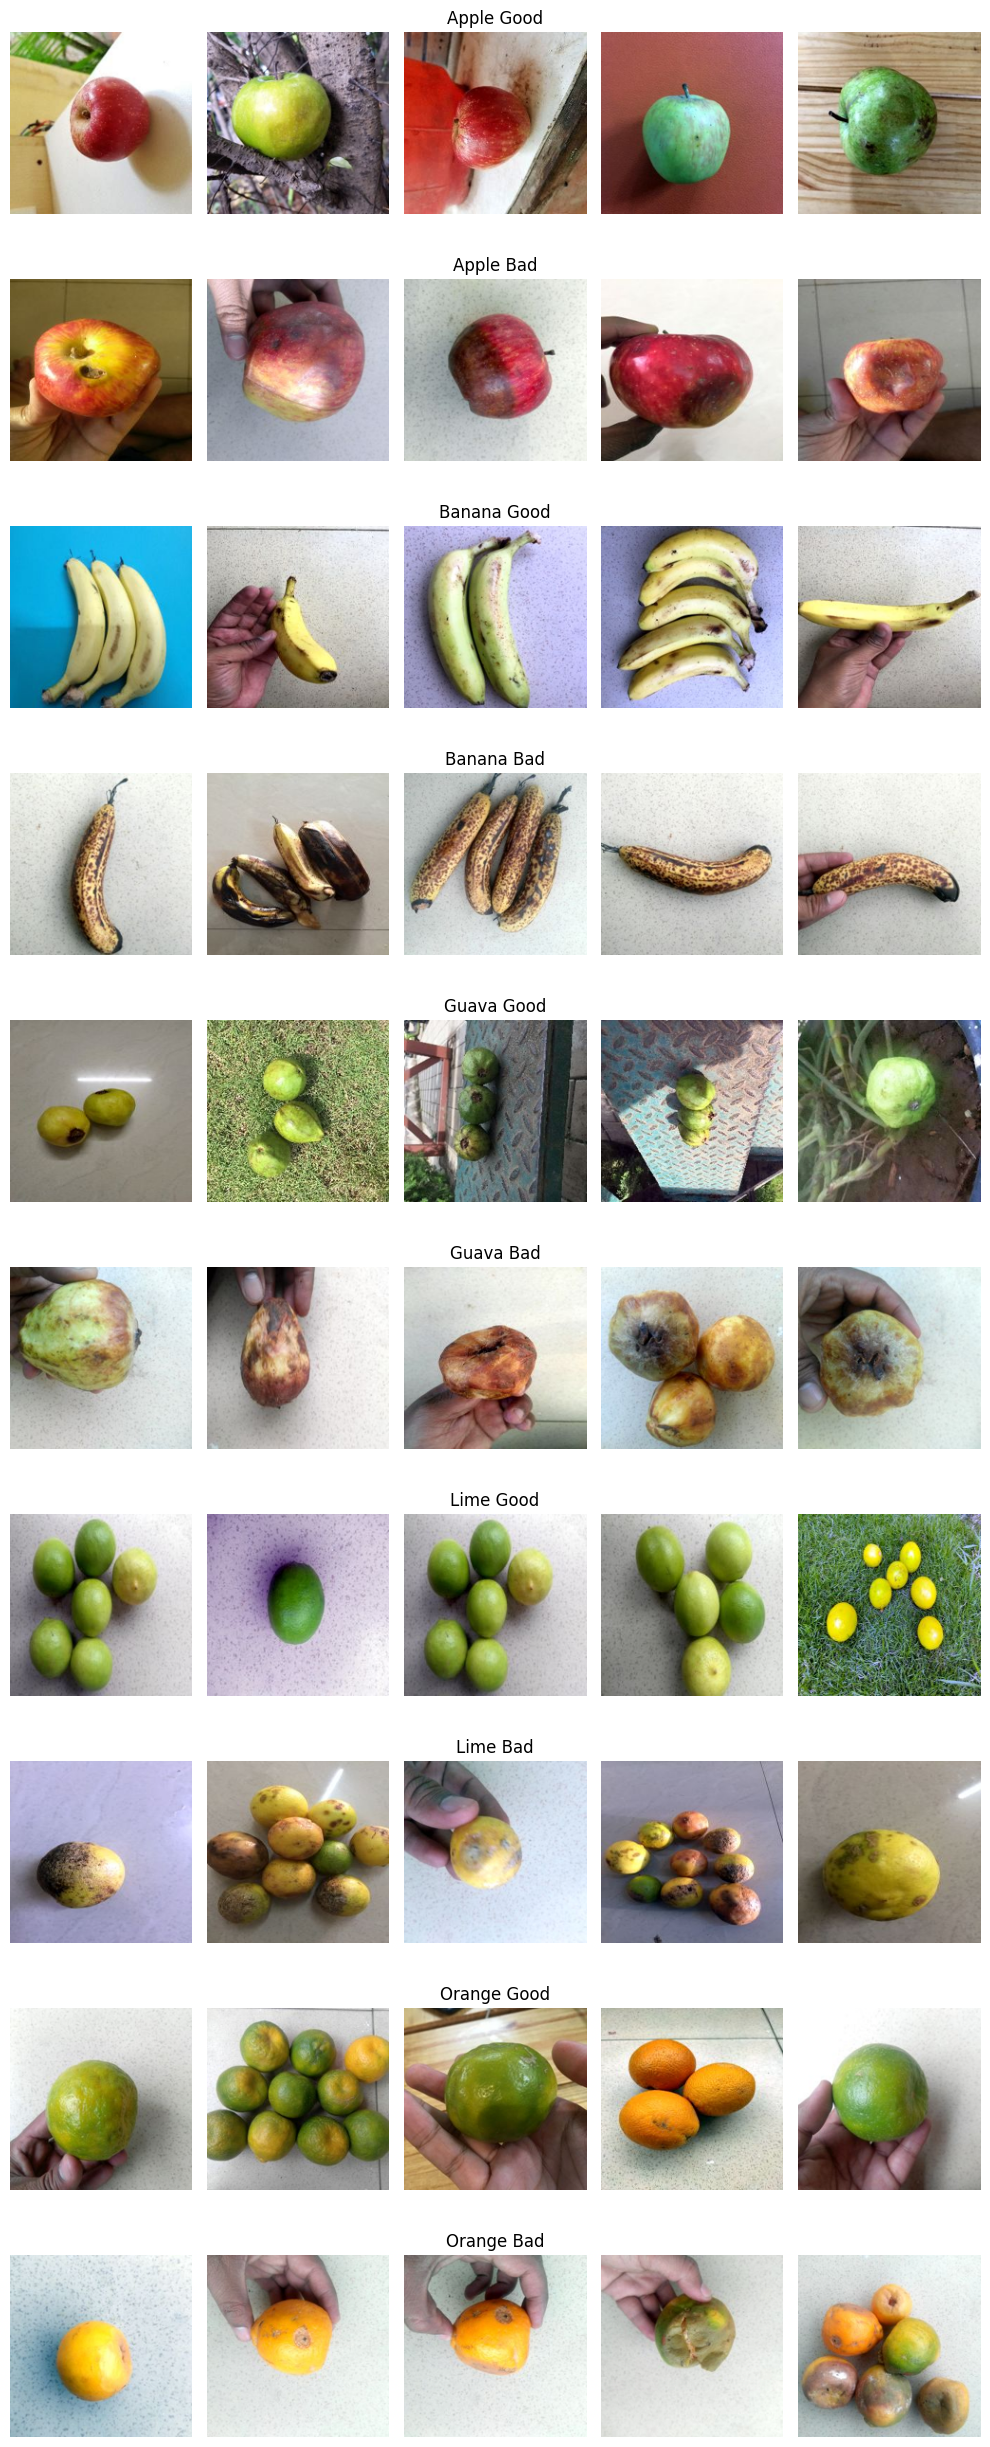

In [ ]:
# =========================================
# Code Block 2: Data Loading & Counting
# =========================================

root_good = "/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits"
root_bad  = "/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits"

# 5 tasks => Apple, Banana, Guava, Lime, Orange
# Each has Good/Bad => 10 classes
label_map = {
    "Apple_Good":   0,
    "Apple_Bad":    1,
    "Banana_Good":  2,
    "Banana_Bad":   3,
    "Guava_Good":   4,
    "Guava_Bad":    5,
    "Lime_Good":    6,
    "Lime_Bad":     7,
    "Orange_Good":  8,
    "Orange_Bad":   9
}

def list_images_in_dir(directory):
    files = []
    if os.path.isdir(directory):
        for fname in os.listdir(directory):
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp")):
                files.append(os.path.join(directory, fname))
    return sorted(files)

def collect_data():
    data_dict = {}
    for cls_name, cls_label in label_map.items():
        if cls_name.endswith("_Good"):
            path_dir = os.path.join(root_good, cls_name)
        else:
            path_dir = os.path.join(root_bad, cls_name)
        items = list_images_in_dir(path_dir)
        data_dict[cls_name] = [(p, cls_label) for p in items]
    return data_dict

data_per_class = collect_data()

print("\nOverall dataset counts (before split):\n")
for cname in sorted(data_per_class.keys()):
    print(f"{cname}: {len(data_per_class[cname])} images")

# 80/20 split
train_data = []
test_data  = []
split_ratio = 0.8
for cname, items in data_per_class.items():
    random.shuffle(items)
    split_idx = int(len(items)*split_ratio)
    train_data += items[:split_idx]
    test_data  += items[split_idx:]

def filter_by_labels(data_list, label_set):
    return [x for x in data_list if x[1] in label_set]

# Tasks (0..4): Apple, Banana, Guava, Lime, Orange
tasks_train = []
tasks_test  = []

tasks_train.append(filter_by_labels(train_data, {0,1}))
tasks_test.append(filter_by_labels(test_data,  {0,1}))

tasks_train.append(filter_by_labels(train_data, {2,3}))
tasks_test.append(filter_by_labels(test_data,  {2,3}))

tasks_train.append(filter_by_labels(train_data, {4,5}))
tasks_test.append(filter_by_labels(test_data,  {4,5}))

tasks_train.append(filter_by_labels(train_data, {6,7}))
tasks_test.append(filter_by_labels(test_data,  {6,7}))

tasks_train.append(filter_by_labels(train_data, {8,9}))
tasks_test.append(filter_by_labels(test_data,  {8,9}))

num_tasks = 5

print()
for i in range(num_tasks):
    print(f"Task {i}: {len(tasks_train[i])} training samples, {len(tasks_test[i])} test samples.")

from collections import Counter
print()
for i in range(num_tasks):
    ctrain = Counter(lbl for _,lbl in tasks_train[i])
    ctest  = Counter(lbl for _,lbl in tasks_test[i])
    print(f"Task {i} label dist - Train: {dict(ctrain)} , Test: {dict(ctest)}")
print()

import torchvision.transforms as T
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Resize & Normalize
common_transform = T.Compose([
    T.Resize((192,192)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

class FruitDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        path, lbl = self.data_list[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, lbl

def visualize_10x5_samples():
    """
    Show a 10x5 grid: each of the 10 classes as a row, 5 images per row.
    """
    class_order = [
        "Apple_Good","Apple_Bad",
        "Banana_Good","Banana_Bad",
        "Guava_Good","Guava_Bad",
        "Lime_Good","Lime_Bad",
        "Orange_Good","Orange_Bad"
    ]
    fig, axs = plt.subplots(10, 5, figsize=(10,25))
    for row, cname in enumerate(class_order):
        items = data_per_class.get(cname, [])
        random.shuffle(items)
        sample_items = items[:5]
        for col, (p, lbl) in enumerate(sample_items):
            img = Image.open(p).convert("RGB").resize((192,192))
            axs[row, col].imshow(img)
            axs[row, col].axis("off")
            if col == 2:
                axs[row, col].set_title(cname.replace("_"," "), fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_10x5_samples()


In [3]:
# =========================================
# Code Block 3: Model & Utilities
# =========================================
import torchvision.models as models
from torchvision.models import ResNet18_Weights

def get_resnet18_model(num_classes):
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

def expand_model_head(model, new_num):
    is_dp = isinstance(model, nn.DataParallel)
    net = model.module if is_dp else model
    old_fc = net.fc
    old_out = old_fc.out_features
    if new_num <= old_out:
        return model
    in_feats = old_fc.in_features
    new_fc = nn.Linear(in_feats, new_num)
    with torch.no_grad():
        new_fc.weight[:old_out] = old_fc.weight
        new_fc.bias[:old_out]   = old_fc.bias
        nn.init.xavier_uniform_(new_fc.weight[old_out:])
        nn.init.constant_(new_fc.bias[old_out:], 0)
    net.fc = new_fc
    return model

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            _, preds = torch.max(outs, 1)
            correct += (preds == lbls).sum().item()
            total   += lbls.size(0)
    return correct / total if total>0 else 0.0

def compute_confusion_matrix(model, data_loader, num_classes=10):
    model.eval()
    cm = np.zeros((num_classes,num_classes), dtype=int)
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            _, preds = torch.max(outs, 1)
            for t, p in zip(lbls.cpu().numpy(), preds.cpu().numpy()):
                cm[t,p] += 1
    return cm

def get_param_count(model):
    """
    Return total number of parameters in the model.
    """
    return sum(p.numel() for p in model.parameters())


In [ ]:
# =========================================
# Code Block 4: Fine-Tuning
# =========================================
def run_fine_tuning(epochs=5, batch_size=128):
    """
    Fine-Tuning:
      - Start from an initial model with 0 output classes
      - For each task t in [0..4]:
         expand to new needed number of classes
         measure param_count
         train only on that new task (time each task)
         evaluate R[t,k] for k in [0..4]
    Returns:
      model, R, cm, param_counts, time_per_task, total_time
    """
    base_model = get_resnet18_model(num_classes=0).to(device)
    if multi_gpu:
        base_model = nn.DataParallel(base_model)

    R = np.zeros((5,5))

    test_loaders = []
    for i in range(num_tasks):
        ds_test = FruitDataset(tasks_test[i], transform=common_transform)
        test_loaders.append(DataLoader(ds_test, batch_size=batch_size, shuffle=False))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

    param_counts = []
    time_per_task = []
    total_time = 0.0

    for t in range(num_tasks):
        needed = max(lbl for _, lbl in tasks_train[t]) + 1
        base_model = expand_model_head(base_model, needed).to(device)
        if multi_gpu and not isinstance(base_model, nn.DataParallel):
            base_model = nn.DataParallel(base_model)

        # measure param_count after expansion
        pcount = get_param_count(base_model)
        param_counts.append(pcount)

        ds_tr = FruitDataset(tasks_train[t], transform=common_transform)
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)

        start_t = time.time()
        for ep in range(epochs):
            base_model.train()
            for imgs, lbls in ld_tr:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                outs = base_model(imgs)
                loss = criterion(outs, lbls)
                loss.backward()
                optimizer.step()
        end_t = time.time()
        elapsed = end_t - start_t
        time_per_task.append(elapsed)
        total_time += elapsed

        # Evaluate => row = t
        for k in range(num_tasks):
            needed_k = max(lbl for _,lbl in tasks_train[k]) + 1
            tmp = copy.deepcopy(base_model)
            tmp = expand_model_head(tmp, needed_k).to(device)
            if multi_gpu and not isinstance(tmp, nn.DataParallel):
                tmp = nn.DataParallel(tmp)
            R[t,k] = evaluate_model(tmp, test_loaders[k])
            del tmp

    # confusion matrix
    all_data = []
    for i in range(num_tasks):
        all_data += tasks_test[i]
    ds_all = FruitDataset(all_data, transform=common_transform)
    ld_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False)
    final_cm = compute_confusion_matrix(base_model, ld_all, num_classes=10)

    return base_model, R, final_cm, param_counts, time_per_task, total_time


In [ ]:
# =========================================
# Code Block 5: Joint
# =========================================
def run_joint(epochs=5, batch_size=128):
    """
    Joint approach:
      - Start from 0-output model
      - For each task t in [0..4]:
         expand to needed classes
         combine data from tasks [0..t]
         measure param_count
         train (time each task)
         evaluate row t
    Returns model, R, cm, param_counts, time_per_task, total_time
    """
    base_model = get_resnet18_model(num_classes=0).to(device)
    if multi_gpu:
        base_model = nn.DataParallel(base_model)

    R = np.zeros((5,5))

    test_loaders = []
    for i in range(num_tasks):
        ds_test = FruitDataset(tasks_test[i], transform=common_transform)
        test_loaders.append(DataLoader(ds_test, batch_size=batch_size, shuffle=False))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

    param_counts = []
    time_per_task = []
    total_time = 0.0

    all_data_so_far = []
    for t in range(num_tasks):
        needed = max(lbl for _, lbl in tasks_train[t]) + 1
        base_model = expand_model_head(base_model, needed).to(device)
        if multi_gpu and not isinstance(base_model, nn.DataParallel):
            base_model = nn.DataParallel(base_model)

        # measure param_count
        pcount = get_param_count(base_model)
        param_counts.append(pcount)

        if t == 0:
            all_data_so_far = tasks_train[0][:]
        else:
            all_data_so_far += tasks_train[t]

        ds_joint = FruitDataset(all_data_so_far, transform=common_transform)
        ld_joint = DataLoader(ds_joint, batch_size=batch_size, shuffle=True)

        start_t = time.time()
        for ep in range(epochs):
            base_model.train()
            for imgs, lbls in ld_joint:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                outs = base_model(imgs)
                loss = criterion(outs, lbls)
                loss.backward()
                optimizer.step()
        end_t = time.time()
        elapsed = end_t - start_t
        time_per_task.append(elapsed)
        total_time += elapsed

        # Evaluate => row t
        for k in range(num_tasks):
            needed_k = max(lbl for _,lbl in tasks_train[k]) + 1
            tmp = copy.deepcopy(base_model)
            tmp = expand_model_head(tmp, needed_k).to(device)
            if multi_gpu and not isinstance(tmp, nn.DataParallel):
                tmp = nn.DataParallel(tmp)
            R[t,k] = evaluate_model(tmp, test_loaders[k])
            del tmp

    # confusion matrix
    all_data_test = []
    for i in range(num_tasks):
        all_data_test += tasks_test[i]
    ds_all = FruitDataset(all_data_test, transform=common_transform)
    ld_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False)
    cm = compute_confusion_matrix(base_model, ld_all, num_classes=10)

    return base_model, R, cm, param_counts, time_per_task, total_time


In [ ]:
# =========================================
# Code Block 6: iCaRL
# =========================================
def run_icarl(epochs=5, batch_size=128, memory_per_class=25):
    from collections import defaultdict
    exemplars = defaultdict(list)

    base_model = get_resnet18_model(num_classes=0).to(device)
    if multi_gpu:
        base_model = nn.DataParallel(base_model)

    R = np.zeros((5,5))

    test_loaders = []
    for i in range(num_tasks):
        ds_te = FruitDataset(tasks_test[i], transform=common_transform)
        test_loaders.append(DataLoader(ds_te, batch_size=batch_size, shuffle=False))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

    param_counts = []
    time_per_task = []
    total_time = 0.0

    for t in range(num_tasks):
        needed = max(lbl for _, lbl in tasks_train[t]) + 1
        base_model = expand_model_head(base_model, needed).to(device)
        if multi_gpu and not isinstance(base_model, nn.DataParallel):
            base_model = nn.DataParallel(base_model)

        # param_count
        pcount = get_param_count(base_model)
        param_counts.append(pcount)

        # Combine new data + exemplars
        cdata = tasks_train[t][:]
        for c in exemplars:
            cdata += exemplars[c]
        ds_comb = FruitDataset(cdata, transform=common_transform)
        ld_comb = DataLoader(ds_comb, batch_size=batch_size, shuffle=True)

        start_t = time.time()
        for ep in range(epochs):
            base_model.train()
            for imgs, lbls in ld_comb:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                outs = base_model(imgs)
                loss = criterion(outs, lbls)
                loss.backward()
                optimizer.step()
        end_t = time.time()
        elapsed = end_t - start_t
        time_per_task.append(elapsed)
        total_time += elapsed

        # build exemplars
        new_labels = set(lbl for _, lbl in tasks_train[t])
        net_u = base_model.module if isinstance(base_model, nn.DataParallel) else base_model
        net_u.eval()
        for c in new_labels:
            cdata_full = [x for x in tasks_train[t] if x[1] == c]
            if len(cdata_full) <= memory_per_class:
                chosen = cdata_full
            else:
                chosen = random.sample(cdata_full, memory_per_class)
            exemplars[c] = chosen

        # evaluate => row t
        for k in range(num_tasks):
            needed_k = max(lbl for _,lbl in tasks_train[k]) + 1
            tmp = copy.deepcopy(base_model)
            tmp = expand_model_head(tmp, needed_k).to(device)
            if multi_gpu and not isinstance(tmp, nn.DataParallel):
                tmp = nn.DataParallel(tmp)
            R[t,k] = evaluate_model(tmp, test_loaders[k])
            del tmp
            
    # confusion matrix
    all_test = []
    for i in range(num_tasks):
        all_test += tasks_test[i]
    ds_all = FruitDataset(all_test, transform=common_transform)
    ld_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False)
    cm = compute_confusion_matrix(base_model, ld_all, num_classes=10)

    return base_model, R, cm, param_counts, time_per_task, total_time


In [ ]:
# =========================================
# Code Block 7: EWC
# =========================================
def run_ewc(epochs=5, batch_size=128, ewc_lambda=100):
    base_model = get_resnet18_model(num_classes=0).to(device)
    if multi_gpu:
        base_model = nn.DataParallel(base_model)

    R = np.zeros((5,5))

    train_loaders = []
    test_loaders  = []
    for i in range(num_tasks):
        ds_tr = FruitDataset(tasks_train[i], transform=common_transform)
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        train_loaders.append(ld_tr)

        ds_te = FruitDataset(tasks_test[i], transform=common_transform)
        ld_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False)
        test_loaders.append(ld_te)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(base_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

    fishers = []
    prev_params = []

    param_counts = []
    time_per_task = []
    total_time = 0.0

    for t in range(num_tasks):
        needed = max(lbl for _,lbl in tasks_train[t]) + 1
        base_model = expand_model_head(base_model, needed).to(device)
        if multi_gpu and not isinstance(base_model, nn.DataParallel):
            base_model = nn.DataParallel(base_model)

        # param_count
        pcount = get_param_count(base_model)
        param_counts.append(pcount)

        start_t = time.time()
        for ep in range(epochs):
            base_model.train()
            for imgs, lbls in train_loaders[t]:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                outs = base_model(imgs)
                loss = criterion(outs, lbls)

                # EWC penalty
                if len(fishers)>0:
                    net = base_model.module if isinstance(base_model, nn.DataParallel) else base_model
                    ewc_loss = 0
                    for fdict, oldp_dict in zip(fishers, prev_params):
                        for name, param in net.named_parameters():
                            if name in fdict:
                                Fval = fdict[name].to(device)
                                old_val = oldp_dict[name].to(device)
                                if param.shape==old_val.shape:
                                    diff = param - old_val
                                    ewc_loss += torch.sum(Fval*(diff**2))
                                else:
                                    min_dim0 = min(param.shape[0], old_val.shape[0])
                                    if param.ndim==2:
                                        min_dim1 = min(param.shape[1], old_val.shape[1])
                                        diff = param[:min_dim0,:min_dim1] - old_val[:min_dim0,:min_dim1]
                                        ewc_loss += torch.sum(Fval[:min_dim0,:min_dim1]*(diff**2))
                                    else:
                                        diff = param[:min_dim0] - old_val[:min_dim0]
                                        ewc_loss += torch.sum(Fval[:min_dim0]*(diff**2))
                    loss += (ewc_lambda/2.0)*ewc_loss
                loss.backward()
                optimizer.step()
        end_t = time.time()
        elapsed = end_t - start_t
        time_per_task.append(elapsed)
        total_time += elapsed

        # fisher
        net_now = base_model.module if isinstance(base_model, nn.DataParallel) else base_model
        net_now.eval()
        fish = {n:torch.zeros_like(p) for n,p in net_now.named_parameters() if p.requires_grad}
        c_samps = 0
        max_samps = 800
        for imgs, lbls in train_loaders[t]:
            net_now.zero_grad()
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = net_now(imgs)
            loss = F.nll_loss(F.log_softmax(outs, dim=1), lbls, reduction='sum')
            loss.backward()
            for name,param in net_now.named_parameters():
                if name in fish:
                    fish[name] += param.grad.detach()**2
            c_samps += lbls.size(0)
            if c_samps>max_samps:
                break
        for name in fish:
            fish[name] /= float(c_samps)
        fishers.append({k:v.cpu() for k,v in fish.items()})
        prev_params.append({k:p.data.cpu().clone() for k,p in net_now.named_parameters()})

        # evaluate row t
        for k in range(num_tasks):
            need_k = max(lbl for _,lbl in tasks_train[k]) + 1
            tmp = copy.deepcopy(base_model)
            tmp = expand_model_head(tmp, need_k).to(device)
            if multi_gpu and not isinstance(tmp, nn.DataParallel):
                tmp = nn.DataParallel(tmp)
            R[t,k] = evaluate_model(tmp, test_loaders[k])
            del tmp

    # confusion matrix
    all_test_data = []
    for i in range(num_tasks):
        all_test_data += tasks_test[i]
    ds_all = FruitDataset(all_test_data, transform=common_transform)
    ld_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False)
    cm = compute_confusion_matrix(base_model, ld_all, num_classes=10)

    return base_model, R, cm, param_counts, time_per_task, total_time


In [ ]:
# =========================================
# Code Block 8: LwF
# =========================================
def run_lwf(epochs=5, batch_size=128, distill_lambda=1.0, distill_temp=10):
    base_model = get_resnet18_model(num_classes=0).to(device)
    if multi_gpu:
        base_model = nn.DataParallel(base_model)

    R = np.zeros((5,5))

    train_loaders = []
    test_loaders  = []
    for i in range(num_tasks):
        ds_tr = FruitDataset(tasks_train[i], transform=common_transform)
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        train_loaders.append(ld_tr)

        ds_te = FruitDataset(tasks_test[i], transform=common_transform)
        ld_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False)
        test_loaders.append(ld_te)

    criterion = nn.CrossEntropyLoss()

    param_counts = []
    time_per_task = []
    total_time = 0.0

    for t in range(num_tasks):
        needed = max(lbl for _, lbl in tasks_train[t]) + 1
        base_model = expand_model_head(base_model, needed).to(device)
        if multi_gpu and not isinstance(base_model, nn.DataParallel):
            base_model = nn.DataParallel(base_model)

        # param_count
        pcount = get_param_count(base_model)
        param_counts.append(pcount)

        optimizer = optim.SGD(base_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

        # old model
        net_u = base_model.module if isinstance(base_model, nn.DataParallel) else base_model
        old_u = copy.deepcopy(net_u).eval().to(device)
        if multi_gpu:
            old_u = nn.DataParallel(old_u)

        start_t = time.time()
        for ep in range(epochs):
            base_model.train()
            for imgs, lbls in train_loaders[t]:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                outs = base_model(imgs)
                loss = criterion(outs, lbls)

                with torch.no_grad():
                    old_outs = old_u(imgs)
                old_num = old_outs.shape[1]
                if old_num>0:
                    new_out_old = outs[:,:old_num]
                    T = distill_temp
                    old_probs = F.softmax(old_outs/T, dim=1)
                    new_logp  = F.log_softmax(new_out_old/T, dim=1)
                    kd_loss   = F.kl_div(new_logp, old_probs, reduction='batchmean')*(T**2)
                    loss += distill_lambda*kd_loss

                loss.backward()
                optimizer.step()
        end_t = time.time()
        elapsed = end_t - start_t
        time_per_task.append(elapsed)
        total_time += elapsed

        # evaluate => row t
        for k in range(num_tasks):
            needed_k = max(lbl for _,lbl in tasks_train[k]) + 1
            tmp = copy.deepcopy(base_model)
            tmp = expand_model_head(tmp, needed_k).to(device)
            if multi_gpu and not isinstance(tmp, nn.DataParallel):
                tmp = nn.DataParallel(tmp)
            R[t,k] = evaluate_model(tmp, test_loaders[k])
            del tmp

    # confusion matrix
    all_test_data = []
    for i in range(num_tasks):
        all_test_data += tasks_test[i]
    ds_all = FruitDataset(all_test_data, transform=common_transform)
    ld_all = DataLoader(ds_all, batch_size=batch_size, shuffle=False)
    cm = compute_confusion_matrix(base_model, ld_all, num_classes=10)

    return base_model, R, cm, param_counts, time_per_task, total_time


In [ ]:
# =========================================
# Code Block 9: Grid Searches
# =========================================

def grid_search_icarl(memory_values=[10, 25, 50], epochs=3, batch_size=128):
    """
    Try different memory_per_class values for iCaRL,
    then print final average accuracy and forgetting (T0..T3 vs T4).
    """
    results = {}
    for mem_val in memory_values:
        print(f"\n--- iCaRL memory_per_class={mem_val} ---\n")
        model_i, R_i, cm_i, _, _, _ = run_icarl(epochs=epochs, batch_size=batch_size, memory_per_class=mem_val)
        final_avg = np.mean(R_i[4,:])  # row=4 => after T4
        forgetting_vals = []
        for old_t in range(4):
            f_drop = R_i[old_t, old_t] - R_i[4, old_t]
            forgetting_vals.append(f_drop)
        print("R_i:\n", R_i)
        print(f"Final average accuracy = {final_avg:.4f}")
        print(f"Forgetting T0..T3 vs T4: {forgetting_vals}")
        results[mem_val] = (final_avg, forgetting_vals)

    print("\nGrid Search iCaRL Results (memory_per_class -> (final avg acc, forgetting)):")
    for mem_val, (acc, fvals) in results.items():
        print(f"mem={mem_val} => final_acc={acc:.4f}, forgetting={fvals}")

def grid_search_ewc(lambda_values=[1, 10, 100, 1000, 10000], epochs=3, batch_size=128):
    """
    Try different ewc_lambda values for EWC, then print final average accuracy + forgetting (T0..T3 vs T4).
    """
    results = {}
    for lv in lambda_values:
        print(f"\n--- EWC ewc_lambda={lv} ---\n")
        model_e, R_e, cm_e, _, _, _ = run_ewc(epochs=epochs, batch_size=batch_size, ewc_lambda=lv)
        final_avg = np.mean(R_e[4,:])
        forgetting_vals = []
        for old_t in range(4):
            f_drop = R_e[old_t, old_t] - R_e[4, old_t]
            forgetting_vals.append(f_drop)
        print("R_e:\n", R_e)
        print(f"Final average accuracy = {final_avg:.4f}")
        print(f"Forgetting T0..T3 vs T4: {forgetting_vals}")
        results[lv] = (final_avg, forgetting_vals)

    print("\nGrid Search EWC Results (ewc_lambda -> (final avg acc, forgetting)):")
    for lv, (acc, fvals) in results.items():
        print(f"lambda={lv} => final_acc={acc:.4f}, forgetting={fvals}")

def grid_search_lwf(distill_vals=[0.1, 1, 2, 5, 10], temp_vals=[1, 2, 5, 10], epochs=3, batch_size=128):
    """
    Try combination of distill_lambda and distill_temp for LwF, then print final average accuracy and forgetting (T0..T3 vs T4).
    """
    results = {}
    for dlmb in distill_vals:
        for dtmp in temp_vals:
            print(f"\n--- LwF distill_lambda={dlmb}, distill_temp={dtmp} ---\n")
            model_l, R_l, cm_l, _, _, _ = run_lwf(epochs=epochs, batch_size=batch_size,
                                                 distill_lambda=dlmb, distill_temp=dtmp)
            final_avg = np.mean(R_l[4,:])
            forgetting_vals = []
            for old_t in range(4):
                f_drop = R_l[old_t, old_t] - R_l[4, old_t]
                forgetting_vals.append(f_drop)
            print("R_l:\n", R_l)
            print(f"Final average accuracy = {final_avg:.4f}")
            print(f"Forgetting T0..T3 vs T4: {forgetting_vals}")
            results[(dlmb, dtmp)] = (final_avg, forgetting_vals)

    print("\nGrid Search LwF Results:")
    for (dlmb, dtmp), (acc, fvals) in results.items():
        print(f"distill_lambda={dlmb}, distill_temp={dtmp} => final_acc={acc:.4f}, forgetting={fvals}")


In [10]:
grid_search_icarl()


--- iCaRL memory_per_class=10 ---



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


R_i:
 [[0.89542484 0.07482993 0.20787746 0.15366972 0.00630252]
 [0.34204793 0.92290249 0.16630197 0.         0.00630252]
 [0.32897603 0.7414966  0.82275711 0.02522936 0.11764706]
 [0.16339869 0.55102041 0.26914661 0.84174312 0.        ]
 [0.06753813 0.49659864 0.27133479 0.30045872 0.8487395 ]]
Final average accuracy = 0.3969
Forgetting T0..T3 vs T4: [0.8278867102396514, 0.42630385487528344, 0.5514223194748359, 0.5412844036697249]

--- iCaRL memory_per_class=25 ---

R_i:
 [[0.93899782 0.02267574 0.00218818 0.         0.        ]
 [0.75816993 0.82312925 0.0809628  0.00229358 0.        ]
 [0.65141612 0.73922902 0.73304158 0.         0.00840336]
 [0.4335512  0.70748299 0.34573304 0.9266055  0.00630252]
 [0.45751634 0.71655329 0.38293217 0.59174312 0.64915966]]
Final average accuracy = 0.5596
Forgetting T0..T3 vs T4: [0.48148148148148145, 0.10657596371882083, 0.35010940919037203, 0.3348623853211009]

--- iCaRL memory_per_class=50 ---

R_i:
 [[0.94771242 0.36281179 0.10284464 0.06422018 0.

In [28]:
grid_search_ewc()


--- EWC ewc_lambda=1 ---

R_e:
 [[0.8627451  0.22675737 0.0678337  0.05045872 0.0210084 ]
 [0.5795207  0.67573696 0.38293217 0.24082569 0.06302521]
 [0.52287582 0.41496599 0.81619256 0.03440367 0.        ]
 [0.17864924 0.3968254  0.33260394 0.92201835 0.01680672]
 [0.33769063 0.20634921 0.29540481 0.72018349 0.62394958]]
Final average accuracy = 0.4367
Forgetting T0..T3 vs T4: [0.5250544662309369, 0.46938775510204084, 0.5207877461706784, 0.2018348623853211]

--- EWC ewc_lambda=10 ---

R_e:
 [[0.92156863 0.02494331 0.20131291 0.         0.31512605]
 [0.09150327 0.89795918 0.1487965  0.04357798 0.        ]
 [0.35294118 0.26530612 0.40043764 0.11697248 0.04201681]
 [0.15904139 0.06349206 0.1356674  0.93119266 0.19747899]
 [0.09803922 0.07029478 0.18161926 0.59633028 0.72268908]]
Final average accuracy = 0.3338
Forgetting T0..T3 vs T4: [0.8235294117647058, 0.8276643990929705, 0.2188183807439825, 0.3348623853211009]

--- EWC ewc_lambda=100 ---

R_e:
 [[0.92156863 0.36961451 0.00218818 0.10

In [5]:
grid_search_lwf()


--- LwF distill_lambda=0.1, distill_temp=1 ---



/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


R_l:
 [[0.94553377 0.47619048 0.32166302 0.10091743 0.2605042 ]
 [0.07843137 0.98412698 0.01969365 0.02293578 0.10504202]
 [0.0043573  0.14058957 0.98468271 0.19266055 0.03151261]
 [0.         0.07936508 0.02407002 0.99311927 0.04831933]
 [0.         0.0861678  0.0940919  0.0206422  0.95168067]]
Final average accuracy = 0.2305
Forgetting T0..T3 vs T4: [0.9455337690631809, 0.8979591836734693, 0.8905908096280087, 0.9724770642201834]

--- LwF distill_lambda=0.1, distill_temp=2 ---

R_l:
 [[0.94117647 0.28571429 0.10503282 0.02981651 0.01470588]
 [0.21568627 0.98639456 0.37199125 0.15137615 0.0105042 ]
 [0.         0.05442177 0.98249453 0.01376147 0.10714286]
 [0.         0.00226757 0.03719912 0.98623853 0.06512605]
 [0.         0.01133787 0.         0.0940367  0.94537815]]
Final average accuracy = 0.2102
Forgetting T0..T3 vs T4: [0.9411764705882353, 0.9750566893424036, 0.9824945295404814, 0.8922018348623852]

--- LwF distill_lambda=0.1, distill_temp=5 ---

R_l:
 [[0.95860566 0.43310658 0.

In [29]:
# =========================================
# Code Block 10: Visualization & run_all
# =========================================
def plot_r_matrix(R, title="R-Matrix"):
    plt.figure(figsize=(6,5))
    sns.heatmap(R, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Test Task")
    plt.ylabel("Train Step")
    plt.show()

def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    if class_names is None:
        class_names = [
            "Apple_Good","Apple_Bad",
            "Banana_Good","Banana_Bad",
            "Guava_Good","Guava_Bad",
            "Lime_Good","Lime_Bad",
            "Orange_Good","Orange_Bad"
        ]
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def compare_forgetting(R, method_name):
    """
    R => 5x5
    Evaluate how each old task T0..T3 forgets by comparing R[t,t] vs R[4,t].
    """
    fvals = []
    for old_t in range(4):  # T0..T3
        f_drop = R[old_t, old_t] - R[4, old_t]
        fvals.append(f_drop)
    print(f"Forgetting for {method_name} => T0,T1,T2,T3 vs T4:", fvals)

def run_all_methods():
    """
    Runs each method (Fine-Tuning, Joint, iCaRL, EWC, LwF) on tasks 0..4,
    prints/plots the R-matrix & confusion, collects param/time usage data.

    Returns a dict 'all_results' with structure:
      {
        "Fine-Tuning": {
           "R": R_ft, "CM": cm_ft,
           "param_counts": [...],
           "time_per_task": [...],
           "total_time": ...,
           "model": model_ft
        },
        ... (Joint, iCaRL, EWC, LwF)
      }
    """
    all_results = {}

    # Fine-Tuning
    print("\n===== Fine-Tuning =====")
    ft_model, ft_R, ft_cm, ft_params, ft_time_tasks, ft_time_total = run_fine_tuning(epochs=5, batch_size=128)
    print("R_ft:\n", ft_R)
    plot_r_matrix(ft_R, "Fine-Tuning R")
    plot_confusion_matrix(ft_cm, title="Fine-Tuning CM")
    compare_forgetting(ft_R, "Fine-Tuning")
    all_results["Fine-Tuning"] = {
        "R": ft_R, "CM": ft_cm,
        "param_counts": ft_params,
        "time_per_task": ft_time_tasks,
        "total_time": ft_time_total,
        "model": ft_model
    }

    # Joint
    print("\n===== Joint =====")
    j_model, j_R, j_cm, j_params, j_time_tasks, j_time_total = run_joint(epochs=5, batch_size=128)
    print("R_j:\n", j_R)
    plot_r_matrix(j_R, "Joint R")
    plot_confusion_matrix(j_cm, title="Joint CM")
    compare_forgetting(j_R, "Joint")
    all_results["Joint"] = {
        "R": j_R, "CM": j_cm,
        "param_counts": j_params,
        "time_per_task": j_time_tasks,
        "total_time": j_time_total,
        "model": j_model
    }

    # iCaRL
    print("\n===== iCaRL =====")
    i_model, i_R, i_cm, i_params, i_time_tasks, i_time_total = run_icarl(epochs=5, batch_size=128, memory_per_class=25)
    print("R_i:\n", i_R)
    plot_r_matrix(i_R, "iCaRL R")
    plot_confusion_matrix(i_cm, title="iCaRL CM")
    compare_forgetting(i_R, "iCaRL")
    all_results["iCaRL"] = {
        "R": i_R, "CM": i_cm,
        "param_counts": i_params,
        "time_per_task": i_time_tasks,
        "total_time": i_time_total,
        "model": i_model
    }

    # EWC
    print("\n===== EWC =====")
    e_model, e_R, e_cm, e_params, e_time_tasks, e_time_total = run_ewc(epochs=5, batch_size=128, ewc_lambda=100)
    print("R_e:\n", e_R)
    plot_r_matrix(e_R, "EWC R")
    plot_confusion_matrix(e_cm, title="EWC CM")
    compare_forgetting(e_R, "EWC")
    all_results["EWC"] = {
        "R": e_R, "CM": e_cm,
        "param_counts": e_params,
        "time_per_task": e_time_tasks,
        "total_time": e_time_total,
        "model": e_model
    }

    # LwF
    print("\n===== LwF =====")
    l_model, l_R, l_cm, l_params, l_time_tasks, l_time_total = run_lwf(epochs=5, batch_size=128,
                                                                      distill_lambda=1, distill_temp=10)
    print("R_l:\n", l_R)
    plot_r_matrix(l_R, "LwF R")
    plot_confusion_matrix(l_cm, title="LwF CM")
    compare_forgetting(l_R, "LwF")
    all_results["LwF"] = {
        "R": l_R, "CM": l_cm,
        "param_counts": l_params,
        "time_per_task": l_time_tasks,
        "total_time": l_time_total,
        "model": l_model
    }

    print("\n===== All Methods Completed =====")
    return all_results


In [ ]:
# =========================================
# Code Block 11: Extended Visual Comparison
# =========================================

def extended_comparison_visuals(all_results):
    """
    This function creates extended comparison plots:
      - Performance on current (R[t,t]) / past tasks (avg R[t,<t])
      - Resource consumption (param_counts)
      - Model size growth
      - Execution time per task & total
      - Plasticity vs. Stability with new axis definitions
      - Additional bar chart for final average accuracy (R[4,:])
    """
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    methods = list(all_results.keys())  # e.g. ["Fine-Tuning", "Joint", "iCaRL", "EWC", "LwF"]

    # 1) Performance on current tasks => row t, col t => R[t,t]
    # 2) Performance on past tasks => average of R[t, 0..t-1]
    curr_acc = {}
    past_acc = {}
    for method in methods:
        R = all_results[method]["R"]
        # Diagonal = new-task performance
        diagonal_acc = [R[t,t] for t in range(5)]
        curr_acc[method] = diagonal_acc

        # average old tasks => R[t, 0..t-1], for t=0 => None
        old_series = []
        for t in range(5):
            if t==0:
                old_series.append(None)
            else:
                old_series.append(np.mean(R[t, :t]))
        past_acc[method] = old_series

    # 3) Resource consumption => param_counts
    # 4) Execution time => time_per_task, total_time
    param_data = {}
    time_per_task_data = {}
    total_time_data = {}
    for method in methods:
        param_data[method] = [p/1e6 for p in all_results[method]["param_counts"]]
        time_per_task_data[method] = all_results[method]["time_per_task"]
        total_time_data[method] = all_results[method]["total_time"]

    # Plot #1: Performance on current tasks (R[t,t])
    plt.figure(figsize=(6,5))
    for method in methods:
        plt.plot(range(5), curr_acc[method], marker='o', label=method)
    plt.title("Performance on Current Experience (R[t,t])")
    plt.xlabel("Task index")
    plt.ylabel("Accuracy")
    plt.ylim(0,1.05)
    plt.xticks(range(5), [0,1,2,3,4])
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot #2: Performance on past tasks (avg R[t,<t])
    plt.figure(figsize=(6,5))
    for method in methods:
        valid_points = [(i,v) for i,v in enumerate(past_acc[method]) if v is not None]
        if len(valid_points) > 0:
            xs = [vp[0] for vp in valid_points]
            ys = [vp[1] for vp in valid_points]
            plt.plot(xs, ys, marker='o', label=method)
    plt.title("Performance on Past Experiences (avg R[t,<t])")
    plt.xlabel("Task index")
    plt.ylabel("Accuracy (avg old tasks)")
    plt.ylim(0,1.05)
    plt.xticks(range(5), [0,1,2,3,4])
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot #3: Model parameter growth (in millions)
    plt.figure(figsize=(6,5))
    for method in methods:
        plt.plot(range(5), param_data[method], marker='s', label=method)
    plt.title("Model Parameter Growth (millions)")
    plt.xlabel("Task index")
    plt.ylabel("Param Count (millions)")
    plt.xticks(range(5), [0,1,2,3,4])
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot #4: Execution time per task
    plt.figure(figsize=(6,5))
    for method in methods:
        times = time_per_task_data[method]
        plt.plot(range(5), times, marker='^', label=method)
    plt.title("Execution Time per Task")
    plt.xlabel("Task index")
    plt.ylabel("Time (sec)")
    plt.xticks(range(5), [0,1,2,3,4])
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot #5: Total training time
    methods_idx = np.arange(len(methods))
    tot_times = [total_time_data[m] for m in methods]
    plt.figure(figsize=(6,4))
    bars = plt.bar(methods_idx, tot_times, color=sns.color_palette("husl", len(methods)))
    plt.title("Total Training Time (All Tasks)")
    plt.ylabel("Time (sec)")
    plt.xticks(methods_idx, methods)
    for i, val in enumerate(tot_times):
        plt.text(i, val+0.05, f"{val:.1f}s", ha='center', va='bottom')
    plt.show()

    # Plot #6: Plasticity vs. Stability
    # X-axis => average diagonal accuracy across tasks => (R[0,0]+R[1,1]+R[2,2]+R[3,3]+R[4,4]) / 5
    # Y-axis => negative sum_of_forgetting => - sum_{t=0..3} [R[t,t] - R[4,t]]
    # So top-right is best
    plt.figure(figsize=(6,5))
    for method in methods:
        R = all_results[method]["R"]
        # average diagonal
        avg_diag = np.mean([R[t,t] for t in range(5)])
        # sum of forgetting
        sum_forgetting = 0.0
        for old_t in range(4):
            sum_forgetting += (R[old_t, old_t] - R[4, old_t])
        neg_forgetting = -sum_forgetting
        plt.scatter(avg_diag, neg_forgetting, s=100, label=method)
        # label near the point
        plt.text(avg_diag, neg_forgetting, method, fontsize=9, ha='left', va='bottom')
    plt.title("Plasticity vs. Stability (Top-Right is best)")
    plt.xlabel("Average Diagonal Accuracy (Plasticity)")
    plt.ylabel("-(Sum of Forgetting) (Stability)")
    plt.xlim(0,1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot #7: Bar chart of final average accuracy on last row => R[4,:]
    plt.figure(figsize=(6,4))
    final_accs = []
    for method in methods:
        R = all_results[method]["R"]
        # final row => R[4,:]
        final_avg_acc = np.mean(R[4,:])
        final_accs.append(final_avg_acc)
    idx = np.arange(len(methods))
    bars = plt.bar(idx, final_accs, color=sns.color_palette("Set2", len(methods)))
    plt.title("Final Average Accuracy (Row=4 across tasks)")
    plt.ylim(0,1.05)
    plt.ylabel("Accuracy")
    plt.xticks(idx, methods)
    for i, val in enumerate(final_accs):
        plt.text(i, val+0.01, f"{val:.2f}", ha='center', va='bottom')
    plt.show()


===== Fine-Tuning =====
R_ft:
 [[0.95424837 0.03854875 0.16630197 0.04587156 0.25      ]
 [0.22875817 0.90702948 0.02844639 0.02522936 0.35714286]
 [0.09586057 0.49206349 0.96717724 0.11238532 0.00420168]
 [0.04139434 0.35827664 0.48140044 0.94036697 0.02521008]
 [0.02396514 0.19501134 0.40700219 0.43348624 0.88655462]]


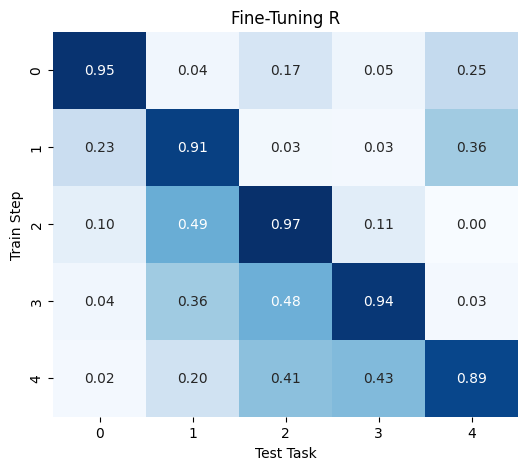

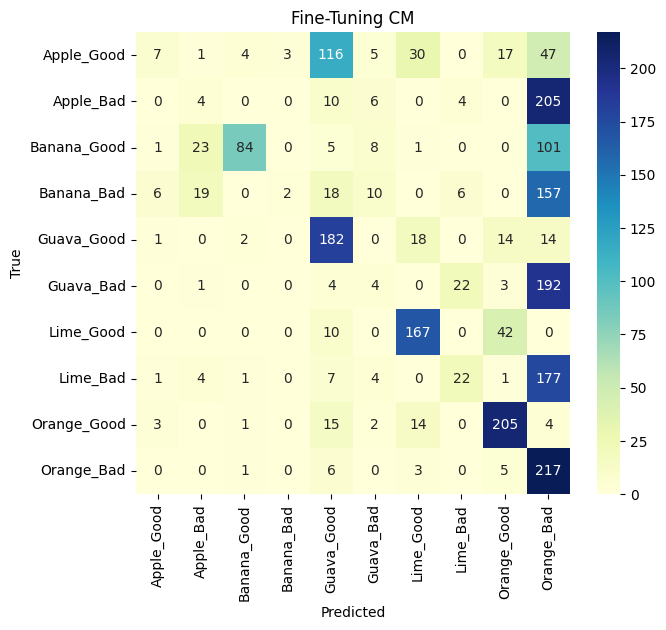

Forgetting for Fine-Tuning => T0,T1,T2,T3 vs T4: [0.9302832244008715, 0.7120181405895691, 0.5601750547045952, 0.5068807339449541]

===== Joint =====


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


R_j:
 [[0.96296296 0.25623583 0.00218818 0.06422018 0.06092437]
 [0.97821351 0.97959184 0.04157549 0.00688073 0.22268908]
 [0.97603486 0.99773243 0.94967177 0.00458716 0.03361345]
 [0.97821351 1.         0.96061269 0.96788991 0.        ]
 [0.97385621 1.         0.95842451 0.9793578  0.87605042]]


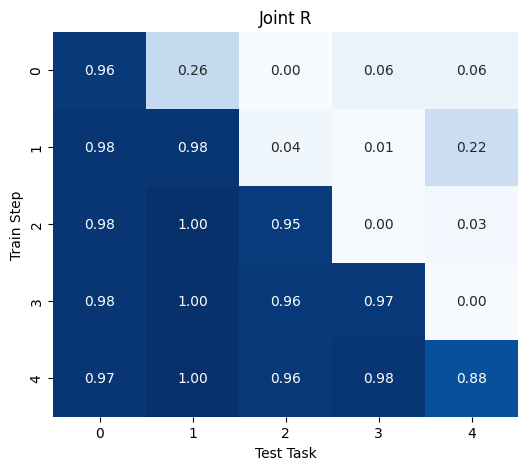

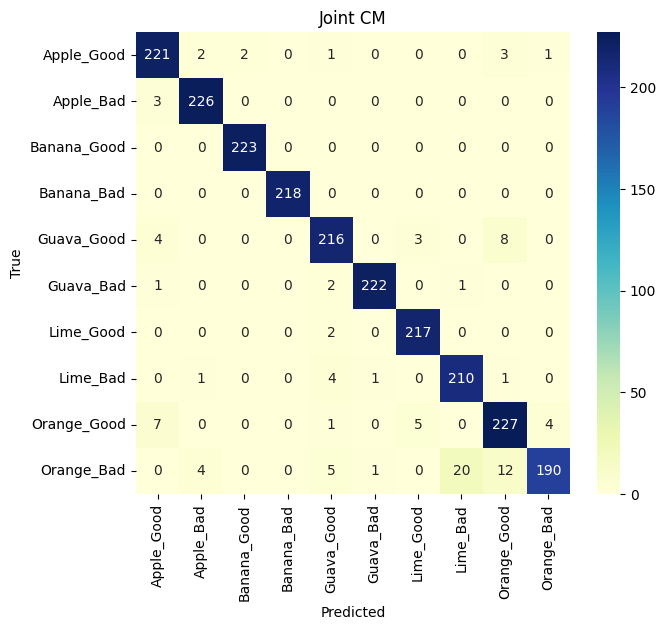

Forgetting for Joint => T0,T1,T2,T3 vs T4: [-0.01089324618736387, -0.020408163265306145, -0.008752735229759279, -0.011467889908256867]

===== iCaRL =====


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


R_i:
 [[0.91503268 0.16780045 0.05908096 0.09174312 0.03991597]
 [0.51633987 0.96598639 0.06126915 0.07568807 0.08193277]
 [0.4291939  0.7324263  0.92560175 0.30504587 0.08193277]
 [0.34204793 0.73469388 0.48140044 0.93348624 0.02310924]
 [0.36819172 0.76190476 0.53610503 0.44954128 0.8907563 ]]


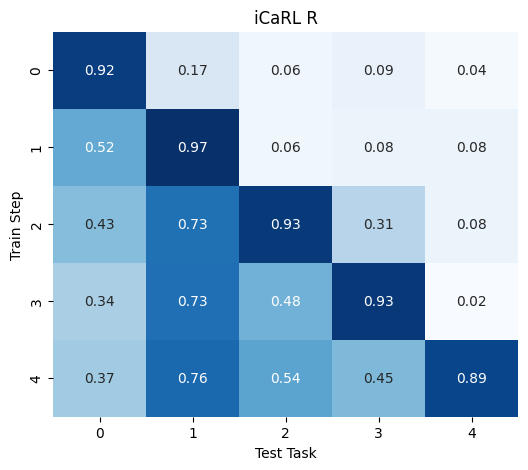

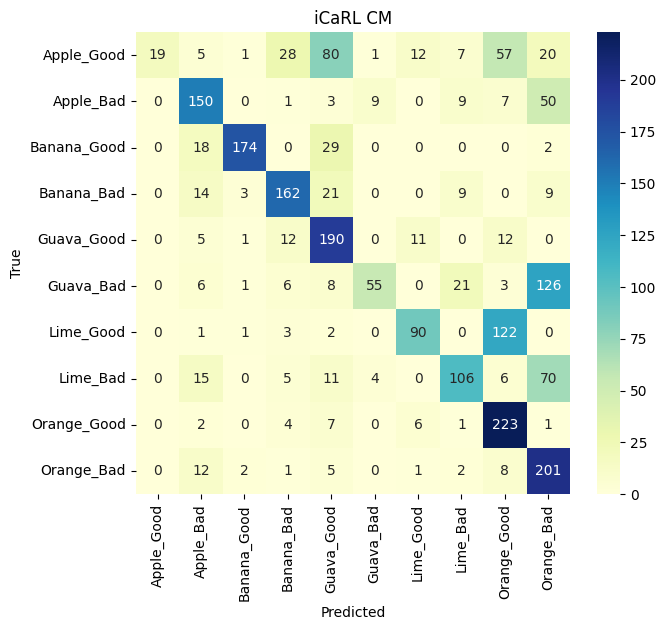

Forgetting for iCaRL => T0,T1,T2,T3 vs T4: [0.5468409586056644, 0.20408163265306123, 0.38949671772428884, 0.48394495412844035]

===== EWC =====


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


R_e:
 [[0.93899782 0.4739229  0.08533917 0.01605505 0.02941176]
 [0.48148148 0.90702948 0.09846827 0.         0.2710084 ]
 [0.44008715 0.78004535 0.89059081 0.15366972 0.39705882]
 [0.24400871 0.2675737  0.19693654 0.98394495 0.1092437 ]
 [0.18736383 0.43537415 0.33916849 0.72706422 0.6197479 ]]


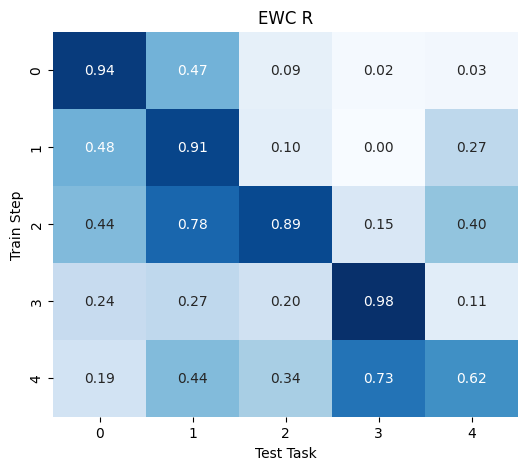

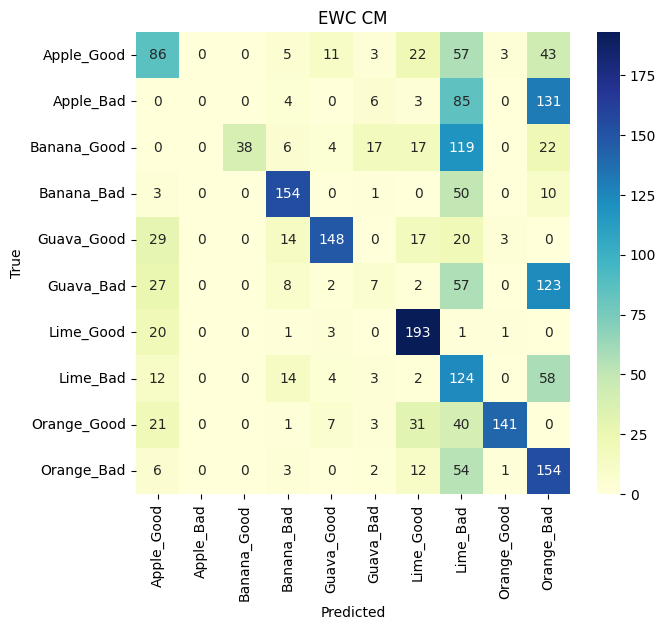

Forgetting for EWC => T0,T1,T2,T3 vs T4: [0.7516339869281046, 0.471655328798186, 0.5514223194748359, 0.25688073394495414]

===== LwF =====


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


R_l:
 [[0.77559913 0.04761905 0.00656455 0.1353211  0.00420168]
 [0.32461874 0.56235828 0.1487965  0.12155963 0.14285714]
 [0.1416122  0.09977324 0.80087527 0.24311927 0.07352941]
 [0.0087146  0.03628118 0.06564551 0.91972477 0.25420168]
 [0.0043573  0.01814059 0.01531729 0.20183486 0.79831933]]


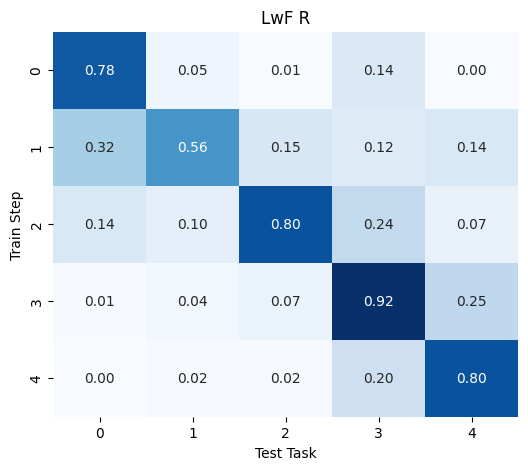

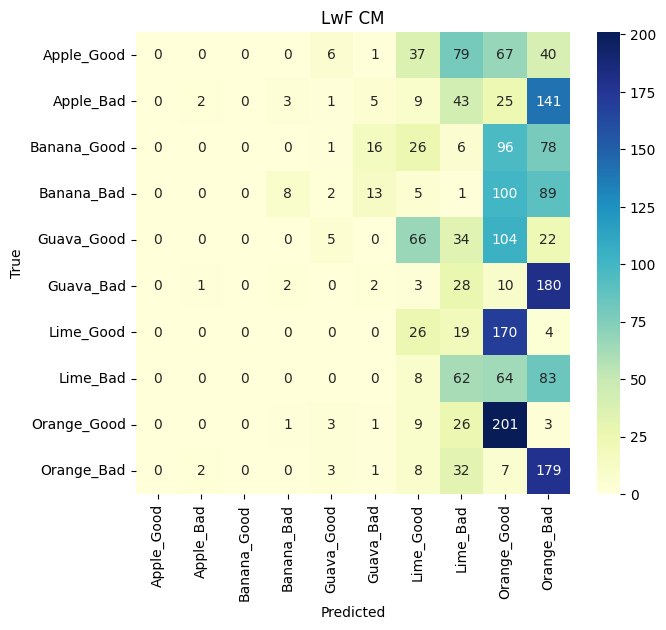

Forgetting for LwF => T0,T1,T2,T3 vs T4: [0.7712418300653595, 0.54421768707483, 0.7855579868708972, 0.7178899082568807]

===== All Methods Completed =====


In [31]:
all_results = run_all_methods()

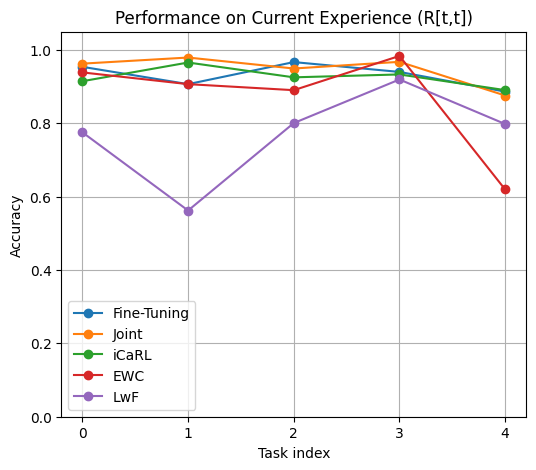

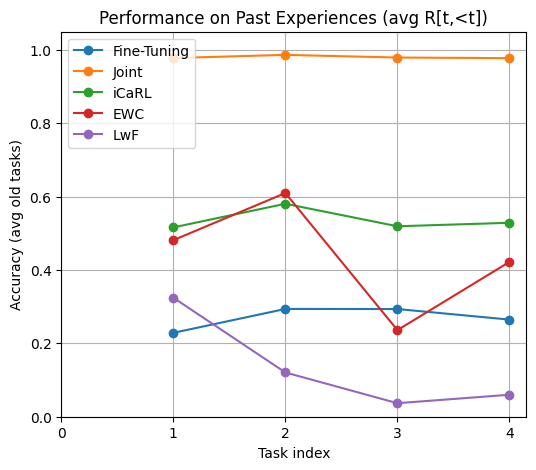

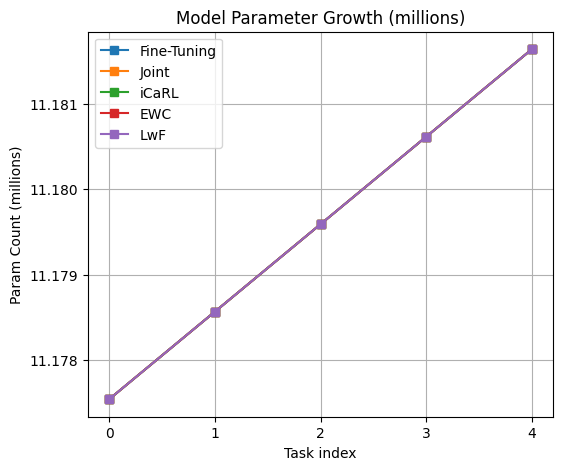

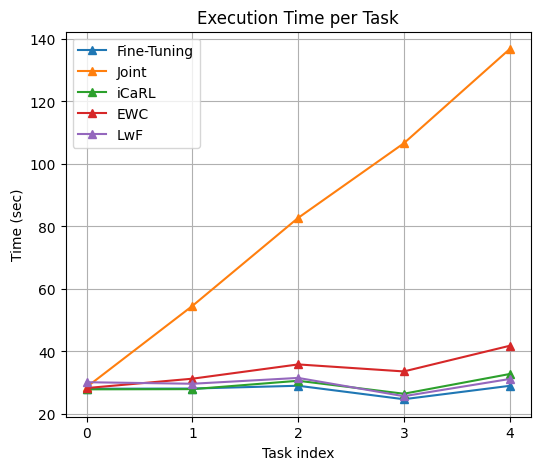

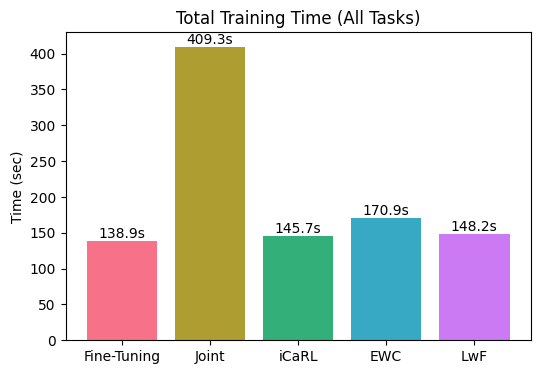

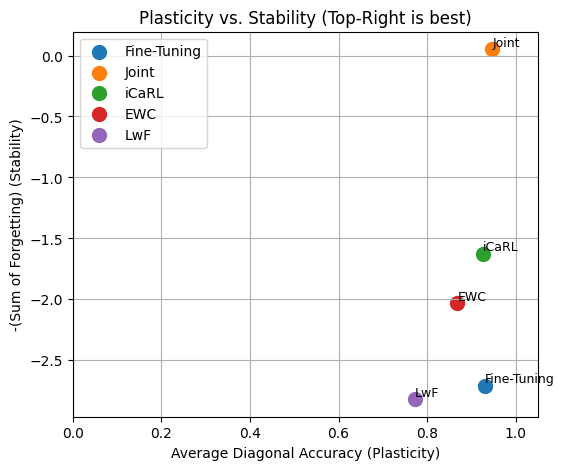

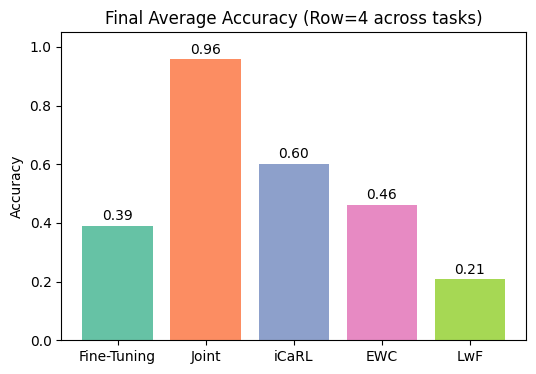

In [32]:
extended_comparison_visuals(all_results)